In [2]:
import fcsfiles as fcs # Small one-man repo, likely has bugs
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [3]:
def get_corr(files, clip=False, dir="../data/2024_09_05-FCSandImg/"):
    '''
    Function to extract correlation from a list of fcs files. 
    Returns times, average of all correlations, and number of traces used (usually more than one per file).
    '''
    if type(files) != list:
        files = [files]
    n_total = 0
    for f in files:
        data = fcs.ConfoCor3Fcs(f'{dir}{f}')
        n_samp = len(data['FcsData']['FcsEntry'])
        n_total += n_samp
        for i in range(n_samp):
            if i==0 and n_total==n_samp: # This should only happen once.
                times_corr = data['FcsData']['FcsEntry'][i]['FcsDataSet']['CorrelationArray'][:,0]
                sum_corr = np.zeros(len(times_corr))
            corr = data['FcsData']['FcsEntry'][i]['FcsDataSet']['CorrelationArray'][:,1]
            if clip:
                corr = corr - corr[clip] + 1
            if len(corr) == 0: # This had to be added because of extra entry in atto488. Probably the average done in ZEN. 
                n_total -= 1
                continue
            sum_corr += corr
        mean_corr = sum_corr/n_total
    return times_corr, mean_corr, n_total

In [34]:
def get_countrate(files, dir="../data/2024_09_05-FCSandImg/"):
    '''
    Function to extract average count rate. Equivelent to relative intesntiy or brightness of the signal.
    Returns the avergae of all traces of all files provided. Uses only the first ~1/5 of the trace. 
    '''
    all_counts = []
    if type(files) != list:
        files = [files]
    for f in files:
        data = fcs.ConfoCor3Fcs(f'{dir}{f}')
        n_samp = len(data['FcsData']['FcsEntry'])
        for i in range(n_samp):
            counts = data['FcsData']['FcsEntry'][i]['FcsDataSet']['CountRateArray'][:,1]
            all_counts.append(np.mean(counts[0:152])) # This should be the first 1 sec of a 5 sec trace. For atto488 it would be first 2 sec...
    return np.mean(all_counts)

In [29]:
def f_includeK(tau, N, tauD, k):
    return 1 + (1/N) * (1/(1+tau/tauD)) * (1/(1+(tau/tauD)*(k**2)))**0.5
def f_standard(tau, N, tauD):
    k = 4.2 # measured below from atto488 control
    return 1 + (1/N) * (1/(1+tau/tauD)) * (1/(1+(tau/tauD)*(k**2)))**0.5
def f_anomalous(tau, N, tauD):
    k = 4.2
    alpha = 0.7
    return 1 + (1/N) * (1/(1+(tau/tauD)**alpha)) * (1/(1+((tau/tauD)**alpha)*(k**2)))**0.5

/tmp/ipykernel_10829/3300818370.py:2: RuntimeWarning: invalid value encountered in sqrt
  return 1 + (1/N) * (1/(1+tau/tauD)) * (1/(1+(tau/tauD)*(k**2)))**0.5


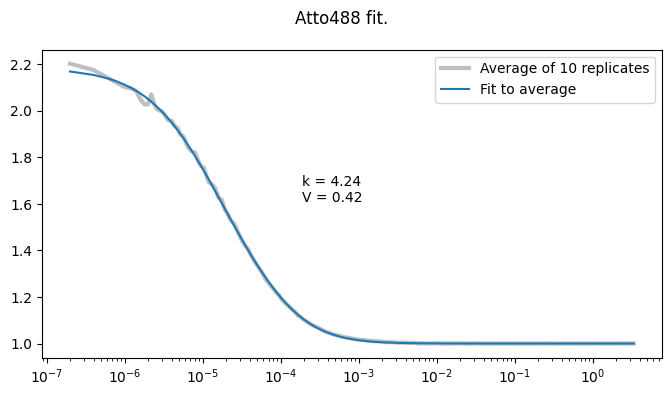

In [24]:
# Calibrate size of focal volume using concentration of atto488
atto2nM = 'atto488_2nM_blocked.fcs'
times_corr, mean_corr, n_total = get_corr(atto2nM, dir="../data/2024_09_10-NiceImgs/")
fit = curve_fit(f_includeK, times_corr, mean_corr, p0=None)
popt, pcov = fit
title = f"Atto488 fit."
fig, axs = plt.subplots(1, 1, figsize=(8,4))
fig.suptitle(title)
axs.set_xscale("log")
axs.plot(times_corr, mean_corr, linewidth=3, alpha=0.5, color="grey", label=f"Average of {n_total} replicates")
axs.plot(times_corr, f_includeK(times_corr, *popt), 
         label="Fit to average")
axs.legend()
fig.text(.45,.5,s=f"k = {round(popt[2],2)} \nV = {round(popt[0]/2,2)}")
V = 0.42

In [35]:
times_corr, mean_corr, n_total = get_corr("Ap4_yeast.fcs", dir="../data/2024_09_10-NiceImgs/", clip=140)
popt, pcov = curve_fit(f_anomalous, times_corr, mean_corr, bounds=(0,100))
counts = get_countrate("Ap4_yeast.fcs", dir="../data/2024_09_10-NiceImgs/")
N = popt[0]
C = N/V
print(C, counts)
print(f"{C/counts} is factor for C per counts")

52.29427128971631 178643.9915707237
0.00029272896798778386 is factor for C per counts


In [38]:
files = ["Ap4_1nuc_unpolarized.fcs", "Ap4_1nuc_polarized.fcs"]
times_corr, mean_corr, n_total = get_corr(files, clip=140)
popt, pcov = curve_fit(f_anomalous, times_corr, mean_corr, bounds=(0,100))
counts = get_countrate(files)
N = popt[0]
C = N/V
print(C, counts)
print(f"{C/counts} is factor for C per counts")

51.60271976480501 250425.06167763157
0.00020606052532886032 is factor for C per counts


In [39]:
files = ["Ap5_1nuc_unpolarized.fcs", "Ap5_moreYeast.fcs"]
times_corr, mean_corr, n_total = get_corr(files, clip=140)
popt, pcov = curve_fit(f_anomalous, times_corr, mean_corr, bounds=(0,100))
counts = get_countrate(files)
N = popt[0]
C = N/V
print(C, counts)
print(f"{C/counts} is factor for C per counts")

22.359382384907466 109877.55847953216
0.00020349362230388966 is factor for C per counts


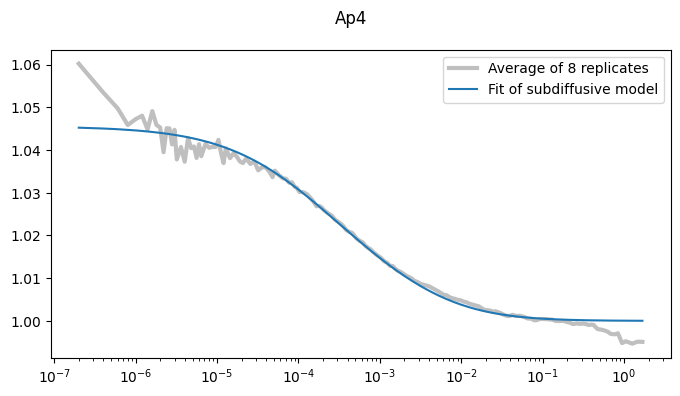

In [32]:
title = "Ap4"
fig, axs = plt.subplots(1, 1, figsize=(8,4))
fig.suptitle(title)
axs.set_xscale("log")
axs.plot(times_corr, mean_corr, linewidth=3, alpha=0.5, color="grey", label=f"Average of {n_total} replicates")
axs.plot(times_corr, f_anomalous(times_corr, *popt), 
         label=f"Fit of subdiffusive model")
axs.legend()

In [41]:
# Get concentrations for each of the polarity probes by FCS
# Get intensity from average of first 1s of trace (could be photobleaching later)
Ap4 = ["Ap4_1nuc_unpolarized.fcs", "Ap4_1nuc_polarized.fcs"]
Ap5 = ["Ap5_1nuc_unpolarized.fcs", "Ap5_moreYeast.fcs"]
Ap6 = ["Ap6_yeast.fcs", "Ap6_polarized_yeast.fcs"]

Sc2 = "Sc2_unbudded.fcs"
Sc3 = "Sc3_unbudded.fcs"
Sc4 = "Sc4_unbudded.fcs"
Sc5 = "Sc5_unbudded.fcs"

popt, pcov = curve_fit(f_anomalous, times_corr[10:140], mean_corr[10:140], bounds=(0,100))

title = "Ap4"
fig, axs = plt.subplots(1, 1, figsize=(8,4))
fig.suptitle(title)
axs.set_xscale("log")
axs.plot(times_corr, mean_corr, linewidth=3, alpha=0.5, color="grey", label=f"Average of {n_total} replicates")
axs.plot(times_corr, f_anomalous(times_corr, *popt), 
         label=f"Fit of subdiffusive model")
axs.legend()

N = popt[0]
C = N/V
C

SyntaxError: invalid syntax (3521778006.py, line 9)

In [ ]:
# Get concentration in the cytosol based on molecular brightness. 
# Plot concentration for yeast, then Ap cells of different sizes. 
